# Understanding Popular Data Science Articles in Medium

In [354]:
import pandas as pd
from datetime import datetime, timedelta,date

In [355]:
def convertToDateString(date):
    return (datetime(1970, 1, 1) + timedelta(milliseconds=date)).strftime("%Y-%m-%d %H:%M:%S")


In [356]:
file_path="medium_search_dataScience/outputs_scrapped/April232018/"
post_file="Posts_20180423_224224.csv"
posts=pd.read_csv(file_path+post_file,encoding='utf-8')
print "Shape of Posts Data is"+ str(posts.shape)

posts['createdDatetime']=posts['createdAt'].apply(convertToDateString)
posts['firstPublishedDatetime']=posts['firstPublishedAt'].apply(convertToDateString)
posts['latestPublishedDatetime']=posts['latestPublishedAt'].apply(convertToDateString)
posts['updatedDatetime']=posts['updatedAt'].apply(convertToDateString)
#posts[['createdAt','createdDatetime']]
posts.to_csv(file_path+"Posts_Preprocessed.csv",encoding='utf-8',index=False)

Shape of Posts Data is(831, 66)


On Medium, on scrapping the search results, we could collect information about number of claps the post got,
number of users who clapped on the post, number of responses, when it was published, what are the tags associated
with it, title of the post, subtitle of the post, language of the post, was it only for Members
and also who wrote that post. To understand what distinguishes a popular post from a non-popular post,
we will have to group posts based on user engagement metric. To normalise the effect of a new post not getting
as many claps or responses, we can use additional measure like number of days between published and scrapped date.

From the 66 columns we have extracted, let us only pull the required columns for Analysis. Also, let us remove all posts which are responses to a particular post.

In [282]:

cols_to_consider=['id','creatorId','firstPublishedDatetime','createdDatetime','ScrappingDate','collectionId','isSubscriptionLocked'
                  ,'language','linksCount','readingTime','recommends','responsesCreatedCount','subTitle','tags_name','title','totalClapCount','wordCount','imageCount']

In [283]:
posts=posts[posts.inResponseToPostId.isnull()]
posts.shape

(800, 70)

In [284]:
posts=posts[cols_to_consider]

In [285]:
posts.shape

(800, 18)

In [286]:
posts.to_csv(file_path+"Posts_Extracted.csv",encoding='utf-8')

In [287]:
def convertStringToDate(dateString,formatString='%Y-%m-%d %H:%M:%S'):
    dates=datetime.strptime(dateString,formatString)
    return dates.date()

def getDaysBetweenDates(date1,date2):
    delta=date1-date2
    return delta.days
    

In [288]:
posts['firstPublishedDate']=posts['firstPublishedDatetime'].apply(convertStringToDate,args=('%Y-%m-%d %H:%M:%S',))
posts['createdDate']=posts['createdDatetime'].apply(convertStringToDate,args=('%Y-%m-%d %H:%M:%S',))


In [289]:
posts['ScrappedDate']=posts['ScrappingDate'].apply(convertStringToDate,args=('%d-%m-%Y',))

In [290]:
posts["PublishAndScrapping_Difference_Days"]=(posts["ScrappedDate"]-posts["firstPublishedDate"]).dt.days

## Features for Clustering - A Hypothesis

1. A more popular article will have more claps 
2. Number of people clapping will be higher
3. Number of days since post was published and the article was scrapped - this is to normalise the user engagement per unit day
4. Is the post only for Subscribers? - if yes, then proportion of user engagement will be lower than for normal article for popular articles



In [291]:
features=['totalClapCount',
          'PublishAndScrapping_Difference_Days',
          'isSubscriptionLocked',
          'responsesCreatedCount',
         'recommends'
         ]

posts_cluster=posts[features]
posts_cluster.shape

(800, 5)

In [292]:
import pylab as pl

from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

def getCluster(data,num_cluster=2):
    kmeans=KMeans(n_clusters=num_cluster)
    kmeans.fit(data)
    return [kmeans.labels_,kmeans.cluster_centers_]

In [293]:
#We want to divide data into popular and non-popular




In [294]:
posts['two_cluster_label']=getCluster(posts_cluster,num_cluster=2)[0]
posts['three_cluster_label']=getCluster(posts_cluster,num_cluster=3)[0]

In [295]:
posts['two_cluster_label'].value_counts()
#Having two cluster gave us 35 articles in one cluster and 765 articles in another

0    765
1     35
Name: two_cluster_label, dtype: int64

In [296]:
posts['three_cluster_label'].value_counts()

0    741
2     47
1     12
Name: three_cluster_label, dtype: int64

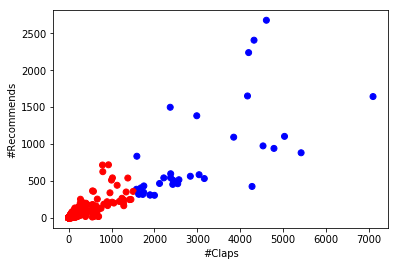

In [297]:
import matplotlib.pyplot as plt
%matplotlib inline
colors = {0:'red', 1:'blue',2:'green',3:'orange'}

def plotScatter(x,y,hues,xlabel,ylabel):
    plt.scatter(x,y,c=hues.apply(lambda x: colors[x]))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

plotScatter(posts['totalClapCount'],posts['recommends'],posts['two_cluster_label'],"#Claps","#Recommends")

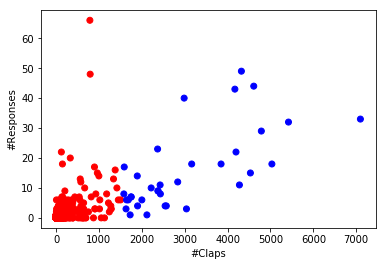

In [298]:
plotScatter(posts['totalClapCount'],posts['responsesCreatedCount'],posts['two_cluster_label'],"#Claps","#Responses")

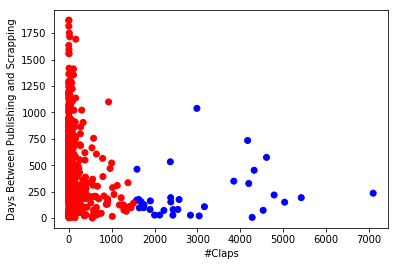

In [299]:
plotScatter(posts['totalClapCount'],posts['PublishAndScrapping_Difference_Days'],posts['two_cluster_label'],"#Claps","Days Between Publishing and Scrapping")

In the graph above, we can see that there are two articles where number of responses is high, but it is put into non-popular group. Also, from the data looks like there can be 3 clusters 

In [300]:
#Let us build clusters after standardising - commented as this didnt give good clusters
'''
from sklearn.preprocessing import StandardScaler
posts_cluster_standardised = StandardScaler().fit_transform(posts_cluster)
posts['two_cluster_label_after_scaling']=getCluster(posts_cluster_standardised,num_cluster=2)[0]
posts['two_cluster_label_after_scaling'].value_counts()

'''


"\nfrom sklearn.preprocessing import StandardScaler\nposts_cluster_standardised = StandardScaler().fit_transform(posts_cluster)\nposts['two_cluster_label_after_scaling']=getCluster(posts_cluster_standardised,num_cluster=2)[0]\nposts['two_cluster_label_after_scaling'].value_counts()\n\n"

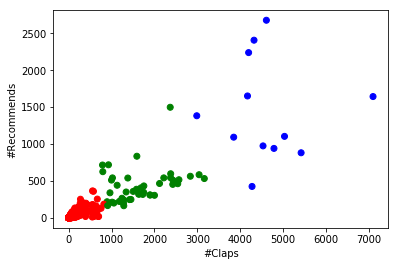

In [301]:
plotScatter(posts['totalClapCount'],posts['recommends'],posts['three_cluster_label'],"#Claps","#Recommends")

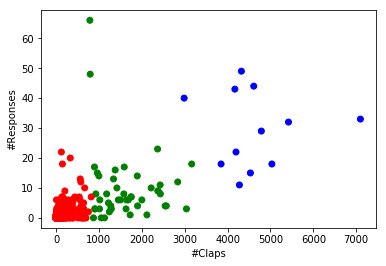

In [302]:
plotScatter(posts['totalClapCount'],posts['responsesCreatedCount'],posts['three_cluster_label'],"#Claps","#Responses")

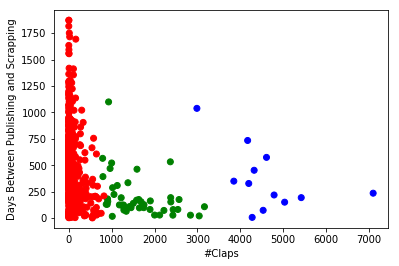

In [303]:
plotScatter(posts['totalClapCount'],posts['PublishAndScrapping_Difference_Days'],posts['three_cluster_label'],"#Claps","Days Between Publishing and Scrapping")

In [307]:
#Rename the clusters and write to csv
clusters={0:'less popularity',1:'high popularity',2:'medium popularity'}
posts['two_cluster_popularity']=posts['two_cluster_label'].apply(lambda x: clusters[x])
posts['three_cluster_popularity']=posts['three_cluster_label'].apply(lambda x:clusters[x])
posts.to_csv(file_path+"Posts_with_Popularity.csv",encoding='utf-8',index=False)

## Understand What makes a Post Popular?
1. What are the common words used in the title?
2. Do popular posts have more links?
3. What is the reading time of popular posts vs non-popular posts?
5. Are there any particular days when a post in published that it gets more readership?
6. Do popular posts have more images?

In [308]:
# Let us create a few features
import re
def getWordCount(text):
    return len(re.findall(r'\w+', text))

In [313]:
posts['TitleWordCount']=posts['title'].apply(getWordCount)

In [352]:
from wordcloud import WordCloud
'''
Create corpus of Titles - join all titles togther
'''
titles=posts['title']
text=""
for title in titles:
    text = text+" "+"".join(title).encode('utf-8').strip()
text
text=text.lower()
wordcloud = WordCloud(relative_scaling=0.5,max_words=300).generate(text)


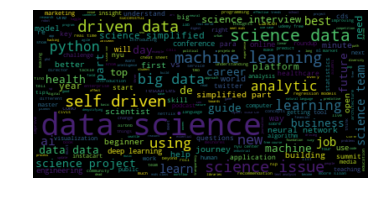

In [357]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.figure(figsize=(40,40))
plt.show()

In [359]:

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize

In [360]:
tags=posts['tags_name']

In [364]:
from nltk.tokenize import wordpunct_tokenize

In [370]:
tags=[tag.replace("[","") for tag in tags]
tags=[tag.replace("]","") for tag in tags]

In [376]:
tags_str=""
for tag in tags:
    tags_str = tags_str+","+"".join(tag).encode('utf-8').strip()

In [426]:
tags_str=tags_str.strip(",")
words=tags_str.split(",")
words=[x for x in words if x]
words=[x.strip() for x in words]
from collections import Counter
counts = Counter(words)
#words

In [428]:

tags_count=pd.DataFrame.from_dict(counts,orient="index")

In [419]:
tags_count=tags_count.reset_index()
#tags_count.columns=['Tags','Frequency']
tags_count=tags_count.rename(columns={'index':'Tags', 0:'Frequency'})

In [420]:
#Number of Tags 
tags_count['Tags'].nunique()
#740 unique Tags were present

660

In [422]:
tags_count.to_csv(file_path+'TagsCount_DataScience.csv',index=False)

In [415]:
posts[["tags_name","id"]].to_csv("Tags_Name.csv",encoding='utf-8')

In [424]:
Counter(words).most_common(10)

[('Data Science', 673),
 ('Machine Learning', 289),
 ('Big Data', 272),
 ('Artificial Intelligence', 128),
 ('Data', 84),
 ('Science', 68),
 ('Analytics', 64),
 ('Python', 63),
 ('Towards Data Science', 44),
 ('Tech', 36)]

In [429]:
from collections import Counter
def getTagsCount(tags):
    tags=[tag.replace("[","") for tag in tags]
    tags=[tag.replace("]","") for tag in tags]
    tags_str=""
    for tag in tags:
        tags_str = tags_str+","+"".join(tag).encode('utf-8').strip()
    tags_str=tags_str.strip(",")
    words=tags_str.split(",")
    words=[x for x in words if x]
    words=[x.strip() for x in words]
 
    counts = Counter(words)
    tags_count=pd.DataFrame.from_dict(counts,orient="index")
    tags_count=tags_count.reset_index()

    tags_count=tags_count.rename(columns={'index':'Tags', 0:'Frequency'})
    return tags_count
    

In [432]:

posts=pd.read_csv(file_path+"Posts_with_Popularity.csv")

In [433]:
high_popular_posts=posts[posts['three_cluster_popularity']=='high popularity']

In [435]:
high_popular_posts_tags=high_popular_posts['tags_name']
tags_count_high_popular=getTagsCount(high_popular_posts_tags)

In [437]:
tags_count_high_popular
tags_count_high_popular.to_csv(file_path+"High_Popular_Tags.csv",index=False)

# What topics do popular and non-popular articles have?